# Running a simple polarimeter
In this tutorial we will simulate a simple polarimeter. We will implement a polarimeter that can only measure linear polarization states. It will consist of a rotating half-wave plate (the polarization modulator) and a linear polarizer (the analyzer). This polarimeter will be a single-beam system, which means that it can only measure one polarization state at the time. Therefore, it will use temporal polarization modulation to measure the other states as well.

For reference on polarimetry, please read...

We start by importing the relevant python modules. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from hcipy import * 

#%matplotlib inline

We will do our measurements with a 4 meter diameter telescope at a wavelength of 500 nanometer. This will set the spatial resolution of the system.  

In [2]:
# parameters telescope
telescope_diameter = 4 # meter 
wavelength = 500E-9 #m

# the spatial resolution of the telescope
spatial_resolution_telescope = wavelength / telescope_diameter

# parameters star
zero_magnitude_flux = 3.9E10
stellar_magnitude = 8

Setting the pupil- and focal-plane grids. We also define the propagator.

In [3]:
# setting the grids
pupil_grid = make_pupil_grid(128, telescope_diameter)
focal_grid = make_focal_grid(q=6, num_airy=10, spatial_resolution=spatial_resolution_telescope)

# the propagator between the pupil- and focal-grid. 
propagator = FraunhoferPropagator(pupil_grid, focal_grid) 

# setting the aperture of the telescope 
aperture = circular_aperture(telescope_diameter)(pupil_grid)

Defining the states of the polarization modulator and the linear polarizer. 

In [4]:
# states of the half-wave plate. 
HWP_state_0 = HalfWavePlate(0)
HWP_state_1 = HalfWavePlate(np.radians(45))
HWP_state_2 = HalfWavePlate(np.radians(22.5))
HWP_state_3 = HalfWavePlate(np.radians(67.5))

# the linear polarizer 
polarizer = LinearPolarizer(0)

In [5]:
detector = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=True)

In [6]:
pupil_wavefront = Wavefront(aperture, wavelength, stokes_vector=np.array([1,0.,1,0]))

pupil_wavefront.total_power = zero_magnitude_flux * 10**(-stellar_magnitude/2.5)
print("Total photon flux {:g}".format(pupil_wavefront.total_power))

Total photon flux 2.46073e+07


We can check the polarization state of the wavefront simply by: 

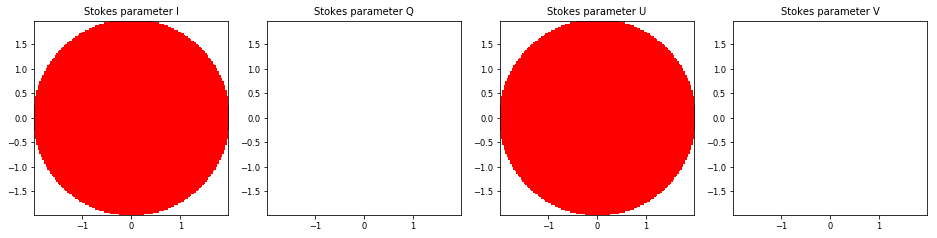

In [7]:
stokes_parameters = [pupil_wavefront.I, pupil_wavefront.Q, pupil_wavefront.U, pupil_wavefront.V]
titles = ['I', 'Q', 'U', 'V']

k=1
plt.figure(figsize=(16, 8))

for stokes_parameter, title in zip(stokes_parameters, titles):
    
    max_val = np.max(np.abs(stokes_parameter))
    
    if max_val == 0:
        max_val = 1

    plt.subplot(1,4,k)

    imshow_field(stokes_parameter, cmap='bwr', vmin=-max_val, vmax=max_val)
    
    plt.title('Stokes parameter ' + title)
    k += 1

Setting up the loop

In [8]:

# total duration of the measurement
loop_duration = 8 # seconds

# number of times we go through the entire modulation loop
N_measurement_sets = 4 # evaluations 

# integration time per modulation state 
delta_t = loop_duration / (N_measurement_sets * 4) 

# counter for the state of the modulation loop 
k = 0 


# The arrays to where we add the measurements 
measurement_vector = Field(np.zeros((4, focal_grid.size)), focal_grid)

for t in np.linspace(0, loop_duration, N_measurement_sets * 4):
    
    # selecting the modulator state
    if k == 0:
        HWP_modulator_state = HWP_state_0
    elif k == 1:
        HWP_modulator_state = HWP_state_1
    elif k == 2:
        HWP_modulator_state = HWP_state_2
    elif k == 3:
        HWP_modulator_state = HWP_state_3
        
    # we propagate the wavefront through the half-wave plate 
    pupil_wavefront_2 = HWP_modulator_state.forward(pupil_wavefront)
    
    # we propagate the wavefront through the linear polarizer 
    pupil_wavefront_3 = polarizer.forward(pupil_wavefront_2)
    
    # propagating the wavefront to the focal-plane
    focal_wavefront = propagator(pupil_wavefront_3)
    
    # integrating the detector
    detector.integrate(focal_wavefront, dt=delta_t)
        
    # reading out the detector in the correct element of the measurement vector
    measurement_vector[k,:] += detector.read_out()
    
    # Moving to the next modulator state 
    k += 1 

    # resetting the modulator 
    if k > 3:
        k = 0

ValueError: lam < 0

Lets plot our four measurements.

In [ ]:
plt.figure(figsize=(16, 8))

for i in np.arange(4):
    plt.subplot(1,4,i+1)
    imshow_field(measurement_vector[i,:])
    
    plt.title('measurement ' + str(i))

We now have our intensity measurement. These need to be converted into polarization states.We do this by using a demodulation matrix, this matrix combines the measurements in such a way such that the original polarization state is retrieved. 

In [ ]:
# defining the modulati
demodulation_matrix = np.zeros((4,4))

# demodulation for I
demodulation_matrix[0,:] = 0.25

# demodulation for Q
demodulation_matrix[1,0] = 0.5
demodulation_matrix[1,1] = -0.5

# demodulation for U
demodulation_matrix[2,2] = 0.5
demodulation_matrix[2,3] = -0.5

print('demodulation matrix = \n', demodulation_matrix)

In [ ]:
stokes_out = field_dot(demodulation_matrix, measurement_vector)

stokes_out /= np.max(stokes_out[0,:])

titles = ['I', 'Q', 'U', 'V']

plt.figure(figsize=(16, 8))

for i in np.arange(4):
    
    max_val = np.max(np.abs(stokes_out[i,:]))
        
    if max_val < 1E-2:
        max_val = 1

    plt.subplot(1,4,i+1)

    if i == 0:
        imshow_field(np.log10(np.abs(stokes_out[i,:])), vmin=-5, vmax=0)
    else:
        imshow_field(stokes_out[i,:], cmap='bwr', vmin=-max_val, vmax=max_val)
    
    plt.title('Stokes parameter ' + titles[i])

plt.show()
    
    